# <font color='blue'>Data Science Academy - Deep Learning Frameworks</font>

## Deep Learning com Theano - Reconhecimento de Imagens com CNNs

As Redes Neurais Convolucionais são um tipo especial de redes neurais de camadas múltiplas. Como quase todas as outras redes neurais, elas são treinadas com uma versão do algoritmo de retro-propagação (Backpropagation). Onde eles diferem é na arquitetura. As Redes Neurais Convolucionais são projetadas para reconhecer padrões visuais diretamente de imagens de pixel com pré-processamento mínimo. Elas podem reconhecer padrões com variabilidade extrema (como caracteres manuscritos), e com robustez a distorções e transformações geométricas simples.

LeNet-5 é uma das mais poderosas aquiteturas de rede convolucional concebida para reconhecimento de caracteres manuscritos e impressos por máquina. 

As Redes Neurais Convolucionais (CNN) são variantes de MLPs de inspiração biológica. Do trabalho inicial de Hubel e Wiesel no córtex visual do gato [Hubel68], sabemos que o córtex visual contém um arranjo complexo de células. Estas células são sensíveis a pequenas sub-regiões do campo visual, chamado de campo receptivo. As sub-regiões são revestidas para cobrir todo o campo visual. Essas células atuam como filtros locais sobre o espaço de entrada e são adequadas para explorar a forte correlação espacialmente local presente em imagens naturais.

Adicionalmente, foram identificados dois tipos de células básicas: As células simples respondem de forma máxima a padrões de borda específicos dentro do seu campo receptivo. As células complexas têm campos receptivos maiores e são localmente invariantes à posição exata do padrão.

O córtex animal visual sendo o sistema de processamento visual mais poderoso existente, parece natural emular o seu comportamento. Assim, muitos modelos de inspiração neuronal podem ser encontrados na literatura. Para citar alguns: o NeoCognitron [Fukushima], HMAX [Serre07] e LeNet-5 [LeCun98], que será o foco deste Jupyter Notebook.

http://yann.lecun.com/exdb/lenet/

In [1]:
# Carregando os pacotes e definindo parâmetros do Theano
import numpy
import theano
import theano.tensor as T
theano.config.floatX = 'float32'

### Camada de Saída - Regressão Logística Multiclasse

Vamos primeiro definir a camada de saída, usada para a previsão, que é semelhante à regressão logística.

In [2]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out):
        # Inicializar com 0 os pesos W como uma matriz de forma (n_in, n_out)
        self.W = theano.shared(value = numpy.zeros((n_in, n_out), dtype = theano.config.floatX), 
                               name = 'W', 
                               borrow = True)
        
        # Inicializar o bias b como um vetor de 0s
        self.b = theano.shared(value = numpy.zeros((n_out,), dtype = theano.config.floatX), 
                               name = 'b', 
                               borrow = True)

        # Expressão simbólica para calcular a matriz de membros de classe 
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # Descrição simbólica de como calcular a predição de uma classe 
        # Retorna índices de elementos máximos obtidos por iteração sobre determinado eixo
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # Parâmetros do modelo
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        """Retorna a média da probabilidade logarítmica negativa da previsão
         deste modelo sob uma dada distribuição-alvo.
        """
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """Retorna um float representando o número de erros no minibatch
         sobre o número total de exemplos do minibatch.
        """

        # Verifica se y tem a mesma dimensão de y_pred
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y deve ter o mesmo shape de self.y_pred', ('y', y.type, 'y_pred', self.y_pred.type))
        
        # Verifique se y é do tipo correto de dado
        if y.dtype.startswith('int'):
            # O operador T.neq retorna um vetor de 0s e 1s, onde 1
            # representa um erro na previsão
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

### Camadas de Convolução e Pooling

Agora podemos começar a definir o código de convolução. Começamos definindo um objeto que representa uma única camada de convolução que faz a operação de convolução real seguida de pooling sobre a saída dessa convolução. Essas camadas serão empilhadas no modelo final.

In [3]:
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d

In [4]:
class LeNetConvPoolLayer(object):
    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        assert image_shape[1] == filter_shape[1]
        self.input = input

        # "Número de input feature maps * altura do filtro * largura do filtro"
        # Entradas para cada unidade oculta
        fan_in = numpy.prod(filter_shape[1:])
        
        # Cada unidade na camada inferior recebe um gradiente de:
        # "Número de output feature maps * altura do filtro * largura do filtro" / pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) / numpy.prod(poolsize))
        
        # Inicializar pesos com pesos aleatórios
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # O bias é um tensor 1D - um bias por output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # Aplica convolução aos input feature maps com filtros
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            input_shape=image_shape
        )

        # Aplicando MaxPooling a cada mapa de recursos individualmente
        pooled_out = pool.pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # Adicione o termo de bias. Como o bias é um vetor (matriz 1D),
        # Precisamos trasnsformá-lo para um tensor de forma (1, n_filters, 1, 1). 
        # Cada bias será, assim, transmitido em mini-batches e feature maps largura x altura
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # Armazena o parâmetro desta camada
        self.params = [self.W, self.b]

### Camada Oculta Totalmente Conectada (Fully Connected)

Vamos também definir uma camada totalmente conectada

In [5]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        self.input = input

        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # Parâmetros do modelo
        self.params = [self.W, self.b]

## Construindo o Modelo

Este método seguinte usa a camada de convolução acima para fazer uma pilha e adicionar uma camada oculta seguida por uma camada de classificação de regressão logística.

Basicamente estamos fazendo isso: Camada de Convolução + Camada Totalmente Conectada + Camada de Saída

In [6]:
import time

theano.config.floatX = 'float32'

In [7]:
def evaluate_lenet5(train_set, test_set, valid_set,
                    learning_rate=0.1, n_epochs=200,
                    nkerns=[20, 50], batch_size=500):
    rng = numpy.random.RandomState(23455)

    # Cria um generator python que retorna minibatches um de cada vez
    def minibatch_generator(dataset):
        dataset_x, dataset_y = dataset
        for i in range(dataset_x.shape[0] // batch_size):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            batch_x = dataset_x[start_idx:end_idx]
            batch_y = dataset_y[start_idx:end_idx]
            yield (batch_x, batch_y)

    x = T.matrix('x')
    y = T.lvector('y')

    # Construir a primeira camada convolucional de pooling:
    # Filtragem reduz o tamanho da imagem para (28-5 + 1, 28-5 + 1) = (24, 24)
    # Maxpooling reduz isso ainda mais para (24/2, 24/2) = (12, 12)
    # Tensor 4D de saída é, portanto, a forma (batch_size, nkerns [0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=x.reshape((batch_size, 1, 28, 28)),
        image_shape=(batch_size, 1, 28, 28),
        filter_shape=(nkerns[0], 1, 5, 5),
        poolsize=(2, 2)
    )

    # Construir a segunda camada de agrupamento convolucional
    # Filtragem reduz o tamanho da imagem para (12-5 + 1, 12-5 + 1) = (8, 8)
    # Maxpooling reduz isso ainda mais para (8/2, 8/2) = (4, 4)
    # Tensor 4D de saída é, portanto, a forma (batch_size, nkerns [1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer0.output,
        image_shape=(batch_size, nkerns[0], 12, 12),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )

    # A HiddenLayer sendo totalmente conectada, opera em matrizes 2D de
    # shape (batch_size, num_pixels) (ou seja, matriz de imagens rasterizadas).
    # Isto irá gerar uma matriz de forma (batch_size, nkerns [1] * 4 * 4),
    # Ou (500, 50 * 4 * 4) = (500, 800) com os valores padrão.
    layer2_input = layer1.output.flatten(2)

    # Construir a camada totalmente conectada.
    layer2 = HiddenLayer(
        rng,
        input=layer2_input,
        n_in=nkerns[1] * 4 * 4,
        n_out=500,
        activation=T.tanh
    )

    # Classificar os valores da camada totalmente conectada
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # O custo que minimizamos durante o treinamento 
    cost = layer3.negative_log_likelihood(y)

    # Criar uma função para calcular os erros que são produzidos pelo modelo
    model_errors = theano.function(
        [x, y],
        layer3.errors(y)
    )

    # Criar uma lista de todos os parâmetros do modelo a serem ajustados por descida do gradiente
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # Criar uma lista de gradientes para todos os parâmetros do modelo
    grads = T.grad(cost, params)

    # Train_model é uma função que atualiza os parâmetros do modelo
    # uma vez que este modelo tem muitos parâmetros, seria tedioso 
    # criar manualmente uma regra de atualização para cada parâmetro do modelo. 
    # Assim, criar a lista de atualizações fazendo um loop automático
    # (Params [i], grads [i]) pares.

    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]

    train_model = theano.function(
        [x, y],
        cost,
        updates=updates
    )

    # Parâmetros de paragem precoce (early-stopping parameters)
    patience = 10000  
    patience_increase = 2

    # Uma melhoria relativa 
    improvement_threshold = 0.995

    n_train_batches = (train_set[0].shape[0] + batch_size - 1) // batch_size
    
    # Passar por este muitos minibatches antes de verificar a rede no
    # conjunto de validação. Neste caso, verificamos todas as épocas
    validation_frequency = min(n_train_batches, patience / 2)

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = time.clock()

    epoch = 0
    iter = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1

        minibatch_index = 0
        for minibatch in minibatch_generator(train_set):
            iter += 1
            minibatch_index += 1
            if iter % 100 == 0:
                print('Treinamento @ iter = %i' % iter)

            error = train_model(minibatch[0], minibatch[1])

            if (iter + 1) % validation_frequency == 0:

                # Computa zero-one loss no conjunto de validação
                validation_losses = [model_errors(vb[0], vb[1]) for vb
                                     in minibatch_generator(valid_set)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, erro de validação %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # Se obtivemos a melhor pontuação de validação até agora
                if this_validation_loss < best_validation_loss:

                    # Aumente o parâmetro "patience" se a melhora de perda é razoável 
                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # Salvar a melhor pontuação de validação eo número de iteração
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # Teste-o no conjunto de teste
                    test_losses = [
                        model_errors(tb[0], tb[1])
                        for tb in minibatch_generator(test_set)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, erro de teste do '
                           'melhor modelo %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = time.clock()
    print('Otimização Concluída.')
    print('Melhor score de validação %f %% obtido na iteração %i, '
          'com teste de performance %f %%' %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))
    print('O código executou em %.2fm' % ((end_time - start_time) / 60.))

    # Isso é para fazer as imagens bonitas nas células abaixo
    layer0_out = theano.function([x], layer0.output)
    layer1_out = theano.function([x], layer1.output)
    
    return params, layer0_out, layer1_out

### Carregando os Dados e Testando o Modelo

Isso carregará uma versão pré-empacotada de MNIST, cada divisão como NumPy ndarrays.

In [8]:
!wget http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz

--2017-05-04 21:41:02--  http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.2’

mnist.pkl.gz.2      100%[===================>]  15.42M  4.25MB/s    in 5.4s    

2017-05-04 21:41:08 (2.85 MB/s) - ‘mnist.pkl.gz.2’ saved [16168813/16168813]



In [9]:
import gzip
import six
import warnings
warnings.filterwarnings('ignore')
from six.moves import cPickle

with gzip.open('mnist.pkl.gz', 'rb') as data_file:
    if six.PY3:
        train_set, valid_set, test_set = cPickle.load(data_file, encoding='latin1')
    else:
        train_set, valid_set, test_set = cPickle.load(data_file)

In [10]:
params, layer0_out, layer1_out = evaluate_lenet5(train_set, test_set, valid_set,
                                                 learning_rate=0.1, n_epochs=5,
                                                 nkerns=[10, 25], batch_size=50)

Treinamento @ iter = 100
Treinamento @ iter = 200
Treinamento @ iter = 300
Treinamento @ iter = 400
Treinamento @ iter = 500
Treinamento @ iter = 600
Treinamento @ iter = 700
Treinamento @ iter = 800
Treinamento @ iter = 900
epoch 1, minibatch 1000/1000, erro de validação 2.540000 %
     epoch 1, minibatch 1000/1000, erro de teste do melhor modelo 2.790000 %
Treinamento @ iter = 1000
Treinamento @ iter = 1100
Treinamento @ iter = 1200
Treinamento @ iter = 1300
Treinamento @ iter = 1400
Treinamento @ iter = 1500
Treinamento @ iter = 1600
Treinamento @ iter = 1700
Treinamento @ iter = 1800
Treinamento @ iter = 1900
epoch 2, minibatch 1000/1000, erro de validação 1.900000 %
     epoch 2, minibatch 1000/1000, erro de teste do melhor modelo 1.900000 %
Treinamento @ iter = 2000
Treinamento @ iter = 2100
Treinamento @ iter = 2200
Treinamento @ iter = 2300
Treinamento @ iter = 2400
Treinamento @ iter = 2500
Treinamento @ iter = 2600
Treinamento @ iter = 2700
Treinamento @ iter = 2800
Treinamen

### Plot

Para a maioria dos modelos de convolução pode ser interessante mostrar o que os filtros treinados "olham". O código abaixo faz isso a partir dos parâmetros retornados pela função de treinamento acima. Neste modelo não há muito efeito, uma vez que os filtros são 5x5 e não podemos ver muito, infelizmente.

(-0.5, 148.5, 58.5, -0.5)

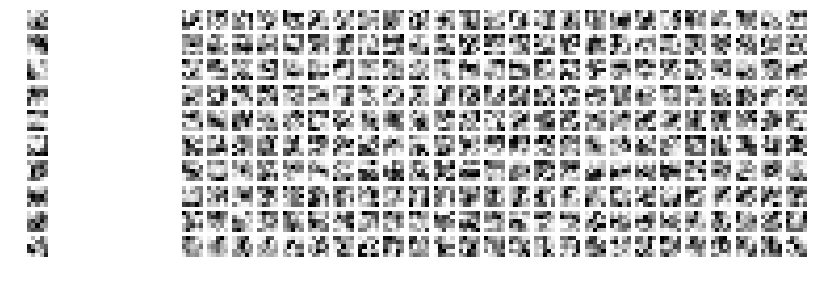

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from utils import tile_raster_images

filts1 = params[6].get_value()
filts2 = params[4].get_value()

plt.clf()

# Aumenta o tamanho da figura
plt.gcf().set_size_inches(15, 10)

# Cria um grid para as duas camadas
gs = plt.GridSpec(2, 2, width_ratios=[1, 25], height_ratios=[1, 1])
a = plt.subplot(gs[0])
b = plt.subplot(gs[1])

# Mostra os filtros de primeira camada 
a.imshow(tile_raster_images(filts1.reshape(10, 25), img_shape=(5, 5), tile_shape=(10, 1), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
a.axis('off')

# Mostre os filtros da segunda camada 
b.imshow(tile_raster_images(filts2.reshape(250, 25), img_shape=(5, 5), tile_shape=(10, 25), tile_spacing=(1,1)),
           cmap="Greys", interpolation="none")
b.axis('off')

O que também pode ser interessante é desenhar as saídas dos filtros para um exemplo. Isso funciona um pouco melhor para este modelo.

(-0.5, 23.5, 23.5, -0.5)

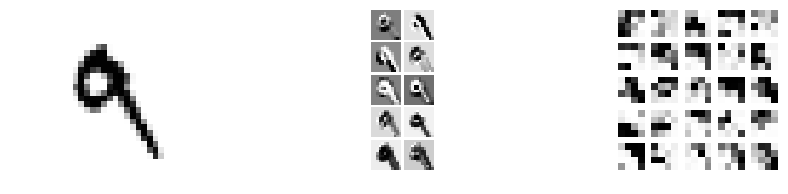

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

from utils import tile_raster_images

# Pegue alguns exemplos de entrada do conjunto de teste 
sample = test_set[0][:50]

# Vamos imprimir este exemplo entre o lote
example = 7

plt.gcf()

# Aumenta o tamanho da figura
plt.gcf().set_size_inches(15, 10)

gs = plt.GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

# Desenha os dados de entrada
a = plt.subplot(gs[0])
a.imshow(sample[example].reshape(28, 28), cmap="Greys", interpolation='none')
a.axis('off')

# Calcula a saída da primeira camada
out0 = layer0_out(sample)[example]

# Desenha a saída
b = plt.subplot(gs[1])
b.imshow(tile_raster_images(out0.reshape(10, 144), img_shape=(12, 12), tile_shape=(5, 2), tile_spacing=(1, 1)),
         cmap="Greys", interpolation='none')
b.axis('off')

# Calcule a saída da segunda camada
out1 = layer1_out(sample)[example]

# Gera a saída
c = plt.subplot(gs[2])
c.imshow(tile_raster_images(out1.reshape(25, 16), img_shape=(4, 4), tile_shape=(5, 5), tile_spacing=(1, 1)),
         cmap="Greys", interpolation='none')
c.axis('off')

### Algumas coisas que você pode tentar com este modelo:

### Alterar a função de ativação da convolução para a unidade retificadora (ReLu).

### Adicionar uma camada extra de convolução


## FIM